# Survery Data Analysis

We use pandas to present some characteristics of our data graphically!

In [163]:
# My exact environment is available in the directory
# however, it's really bloated and I suggest you
# manually install the necessary packages

%matplotlib inline

In [164]:
import pandas as pd

In [165]:
df = pd.read_csv('questionario_2_post_pulizia.csv')

In [166]:
df["usa_mezzi"] = df["usa_mezzi"].replace({"Si": True, "No": False})
df["interesse_posizione"] = df["interesse_posizione"].replace({"Si": True, "No": False})

Ecco una rapida occhiata al Dataframe:

In [167]:
# Il df è di questa forma
# Index(['orario', 'eta', 'dispositivo', 'usa_mezzi', 'freq_mezzi',
#       'provincia_mezzi', 'che_mezzi', 'disservizi', 'applicazioni',
#       'affidabilita_app', 'interesse_crowdsource', 'interesse_partecipazione',
#       'interesse_posizione', 'preferenza_salita', 'interesse_classifica',
#       'interesse_sblocco_feature', 'interesse_sblocco_custom',
#       'interesse_donazioni', 'suggerimenti', 'Treno', 'Bus', 'Tram', 'Metro',
#       'province'],
#      dtype='object')

In [168]:
cols = ["orario", "eta", "dispositivo", "applicazioni", "provincia_mezzi", "disservizi"]

# display head

df[cols].head()

,orario,eta,dispositivo,applicazioni,provincia_mezzi,disservizi
0,01/05/2023 15.47.08,18-25,Android,Google Maps,Milano,"Ritardi, Irregolarità del servizio, Mancanza d..."
1,01/05/2023 15.47.20,18-25,iOS,"Moovit, Google Maps, Maps (Apple), App Cotral",Roma,"Ritardi, Irregolarità del servizio, Mancanza d..."
2,01/05/2023 15.47.24,18-25,Android,Google Maps,Napoli,"Ritardi, Mancanza di copertura, Sovraffollamen..."
3,01/05/2023 15.47.56,25-35,Android,"Moovit, Google Maps",Bologna,"Mancanza di copertura, Scarsa accessibilità, S..."
4,01/05/2023 15.49.28,18-25,iOS,"Google Maps, Maps (Apple)",Napoli,"Ritardi, Irregolarità del servizio, Sovraffoll..."


Per prima cosa, guardiamo rapidamente che dispositivi sono stati utilizzati:

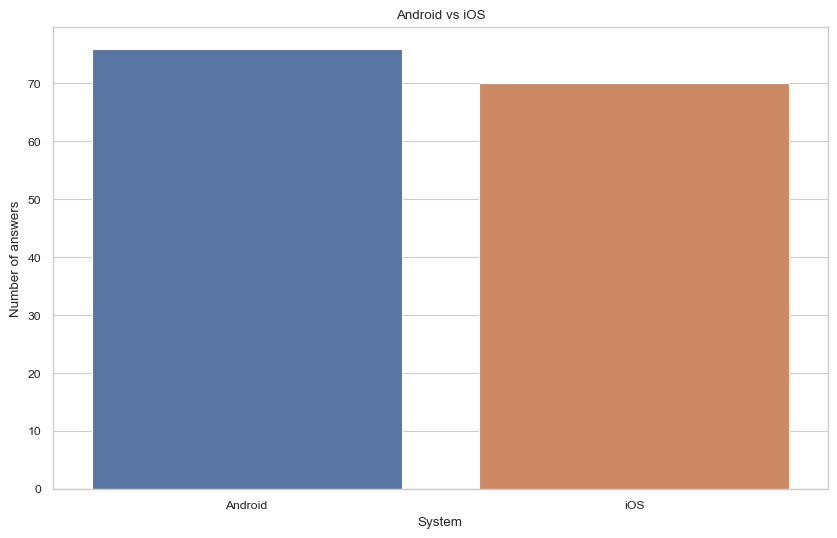

In [169]:
#group by dispositivo (Android, iOS)

devices = df.groupby('dispositivo')

import seaborn as sns
import matplotlib.pyplot as plt

#paper style
sns.set_theme(style="whitegrid")
sns.set_context("paper")

#plot

fig, ax = plt.subplots(figsize=(10, 6))

sns.countplot(x="dispositivo", data=df, ax=ax)

ax.set_title("Android vs iOS")

ax.set_xlabel("System")

ax.set_ylabel("Number of answers")

plt.savefig("../report/img/analysis/android_v_ios.svg", format="svg", bbox_inches = "tight")


Diamo anche un occhiata alle provincie:

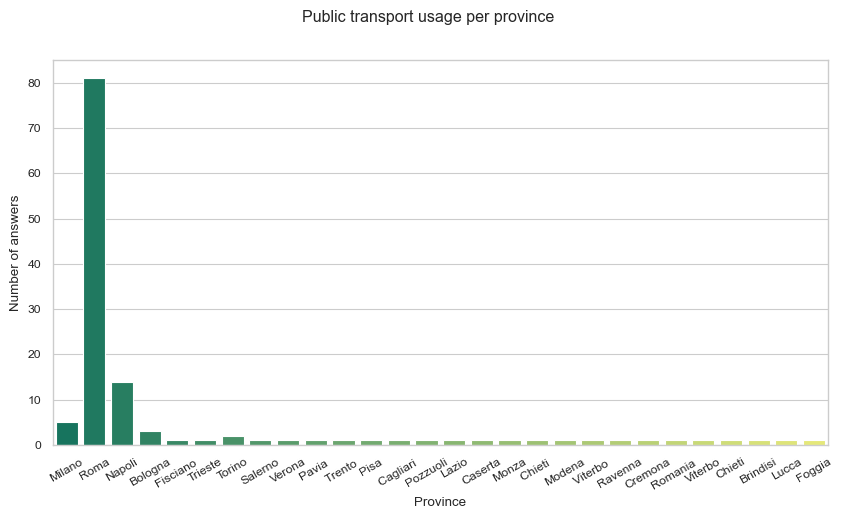

In [170]:
# plot answers by province

fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(x="provincia_mezzi", data=df, ax=ax,palette="summer")

ax.set_xticklabels(rotation=30, labels=ax.get_xticklabels())

ax.set(xlabel='Province', ylabel='Number of answers')

fig.suptitle('Public transport usage per province')

plt.savefig("../report/img/analysis/public_transport_usage_per_province.svg", format="svg", bbox_inches = "tight")


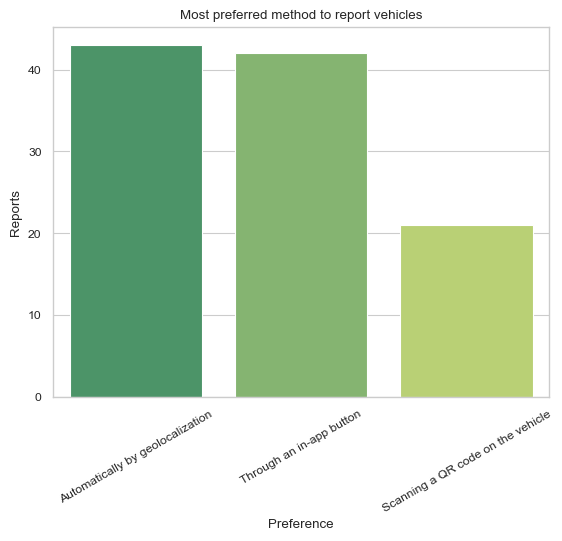

In [171]:
df = df.rename(columns={"preferenza_salita":"preference"})
df.preference = df.preference.str.replace("Scannerizzando un QR code sul mezzo", "Scanning a QR code on the vehicle").str.replace("Tramite un bottone in-app", "Through an in-app button").str.replace("Automaticamente grazie alla geolocalizzazione", "Automatically by geolocalization")
preference = df["preference"].str.split(",", expand=True).stack().str.strip().value_counts()

preference = preference[preference > 1]

preference = preference.reset_index()
preference.columns = ["preference", "reports"]

g = sns.barplot(x="preference", y="reports", data=preference, palette="summer")

g.set_xticklabels(rotation=30, labels=g.get_xticklabels())
g.set(xlabel='Preference', ylabel='Reports')
g.set_title("Most preferred method to report vehicles")

plt.savefig("../report/img/analysis/most_preferred_method_to_report.svg", format="svg", bbox_inches = "tight")

Ci accorgiamo che la maggior parte delle persone proviene da Roma (no surprise), una minoranza delle risposte
arriva anche da Napoli e Milano

Per proseguire, diamo uno sguardo anche alle risposte in ordine di età.

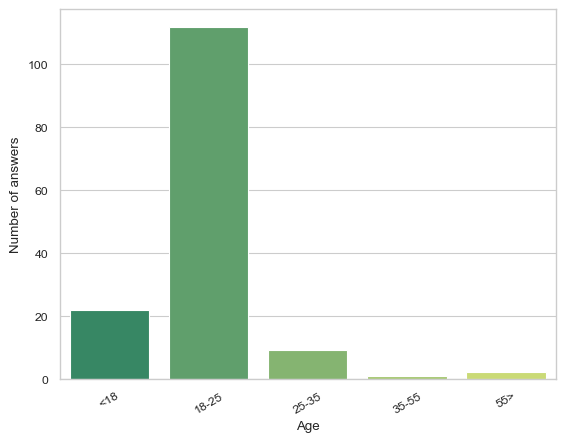

In [172]:
# Number of answers by age group
g = sns.countplot(x="eta", data=df, palette="summer", order=["<18", "18-25", "25-35", "35-55", "55>"])

g.set(xlabel='Age', ylabel='Number of answers')
g.set_xticklabels(rotation=30, labels=g.get_xticklabels())

fig.suptitle('Age distribution')

plt.savefig("../report/img/analysis/age_distribution.svg", format="svg", bbox_inches = "tight")


Adesso guardiamo i mezzi di trasporto preferiti, e, per curiosità, incrociamoli
con i dispositivi utilizzati

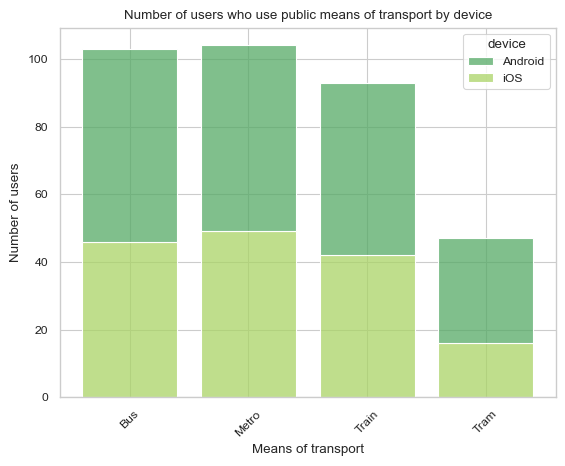

In [173]:
mezzi = ["Treno", "Bus", "Tram", "Metro"]
mezzi_t = ["Train", "Bus", "Tram", "Metro"]

# split the "che_mezzi" column and create a new column for each mean of transport
for mezzo, mezzo_t in zip(mezzi,mezzi_t):
    df[mezzo_t] = df["che_mezzi"].str.contains(mezzo)
    #df[mezzo_t] = df[mezzo]

df = df.rename(columns={"dispositivo":"device"})

# melt the DataFrame to convert the new columns to a "mezzi" column and a "value" column
melted_df = pd.melt(df, id_vars=["device"], value_vars=mezzi_t, var_name="mezzi", value_name="value")

# group the melted DataFrame by "mezzi" and "usa_mezzi" and count the number of users who use each mean of transport
counts_df = melted_df.groupby(["mezzi", "device"])["value"].sum().reset_index(name="count")

# create a barplot to display the results
sns.histplot(data=counts_df, x="mezzi", weights="count", stat="count", shrink=0.8, palette="summer", hue="device", multiple="stack", discrete=True)

# set the title and the labels
plt.title("Number of users who use public means of transport by device")
plt.xlabel("Means of transport")
plt.ylabel("Number of users")
plt.xticks(rotation=45)

plt.savefig("../report/img/analysis/users_by_means_of_transport_by_device.svg", format="svg", bbox_inches = "tight")


Passiamo a un dato importante: i disservizi (rilevanti) più segnalati:

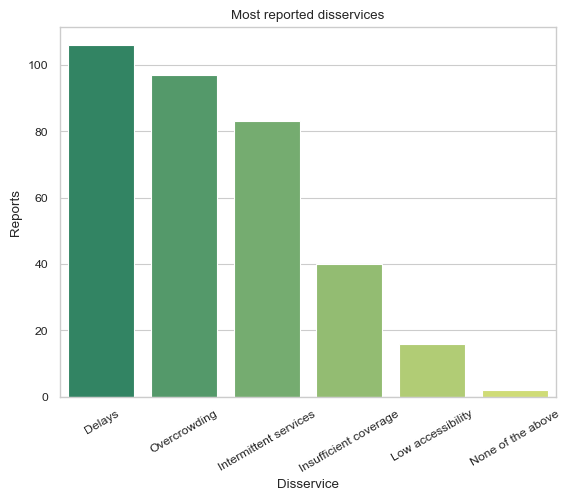

In [174]:
# disservizi contains a list of disservizi separated by a comma, collect all the unique disservizi
# filter only the ones that appear more than twice

df = df.rename(columns={"disservizi":"disservices"})
df.disservices = df.disservices.str.replace("Ritardi", "Delays").str.replace("Sovraffollamento dei mezzi", "Overcrowding").str.replace("Irregolarità del servizio", "Intermittent services").str.replace("Mancanza di copertura", "Insufficient coverage").str.replace("Scarsa accessibilità", "Low accessibility").str.replace("Nessuno tra questi", "None of the above")
disservizi = df["disservices"].str.split(",", expand=True).stack().str.strip().value_counts()

disservizi = disservizi[disservizi > 1]

disservizi = disservizi.reset_index()
disservizi.columns = ["disservices", "reports"]

g = sns.barplot(x="disservices", y="reports", data=disservizi, palette="summer")

g.set_xticklabels(rotation=30, labels=g.get_xticklabels())
g.set(xlabel='Disservice', ylabel='Reports')
g.set_title("Most reported disservices")
plt.savefig("../report/img/analysis/disservices_reports.svg", format="svg", bbox_inches = "tight")

adesso, per ogni provincia, diamo un occhiata ai mezzi pubblici più usati

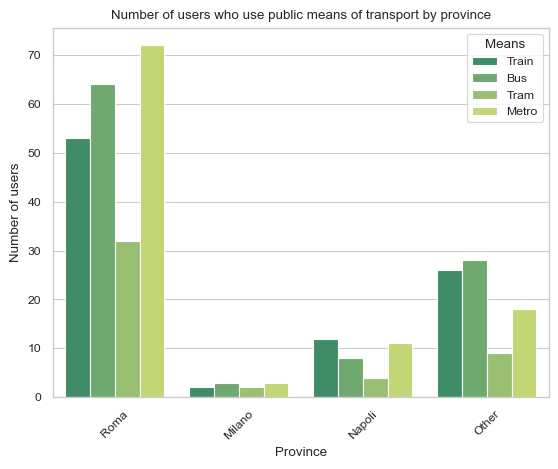

In [175]:
# create a new column for the province of each user
df["province"] = df["provincia_mezzi"].apply(lambda x: x if x in ["Roma", "Milano", "Napoli"] else "Other")

# split the "che_mezzi" column and create a new column for each mean of transport
for mezzo, mezzo_t in zip(mezzi, mezzi_t):
    df[mezzo_t] = df["che_mezzi"].str.contains(mezzo)

# melt the DataFrame to convert the new columns to a "mezzi" column and a "value" column
melted_df = pd.melt(df, id_vars=["province"], value_vars=mezzi_t, var_name="Means", value_name="value")

# group the melted DataFrame by "province" and "Mezzi" and count the number of users who use each mean of transport
counts_df = melted_df.groupby(["province", "Means"])["value"].sum().reset_index(name="count")

# create a barplot to display the results
sns.barplot(data=counts_df, x="province", y="count", hue="Means", palette="summer", dodge=True, hue_order=mezzi_t, order=["Roma", "Milano", "Napoli", "Other"])

# set the order of the xticks

# set the title and the labels
plt.title("Number of users who use public means of transport by province")
plt.xlabel("Province")
plt.ylabel("Number of users")
plt.xticks(rotation=45)
plt.savefig("../report/img/analysis/users_by_means_of_transport_by_province.svg", format="svg", bbox_inches = "tight")

Un grafico completo (ma piuttosto impegnativo) che incrocia le varie preferenze in 
base all età:

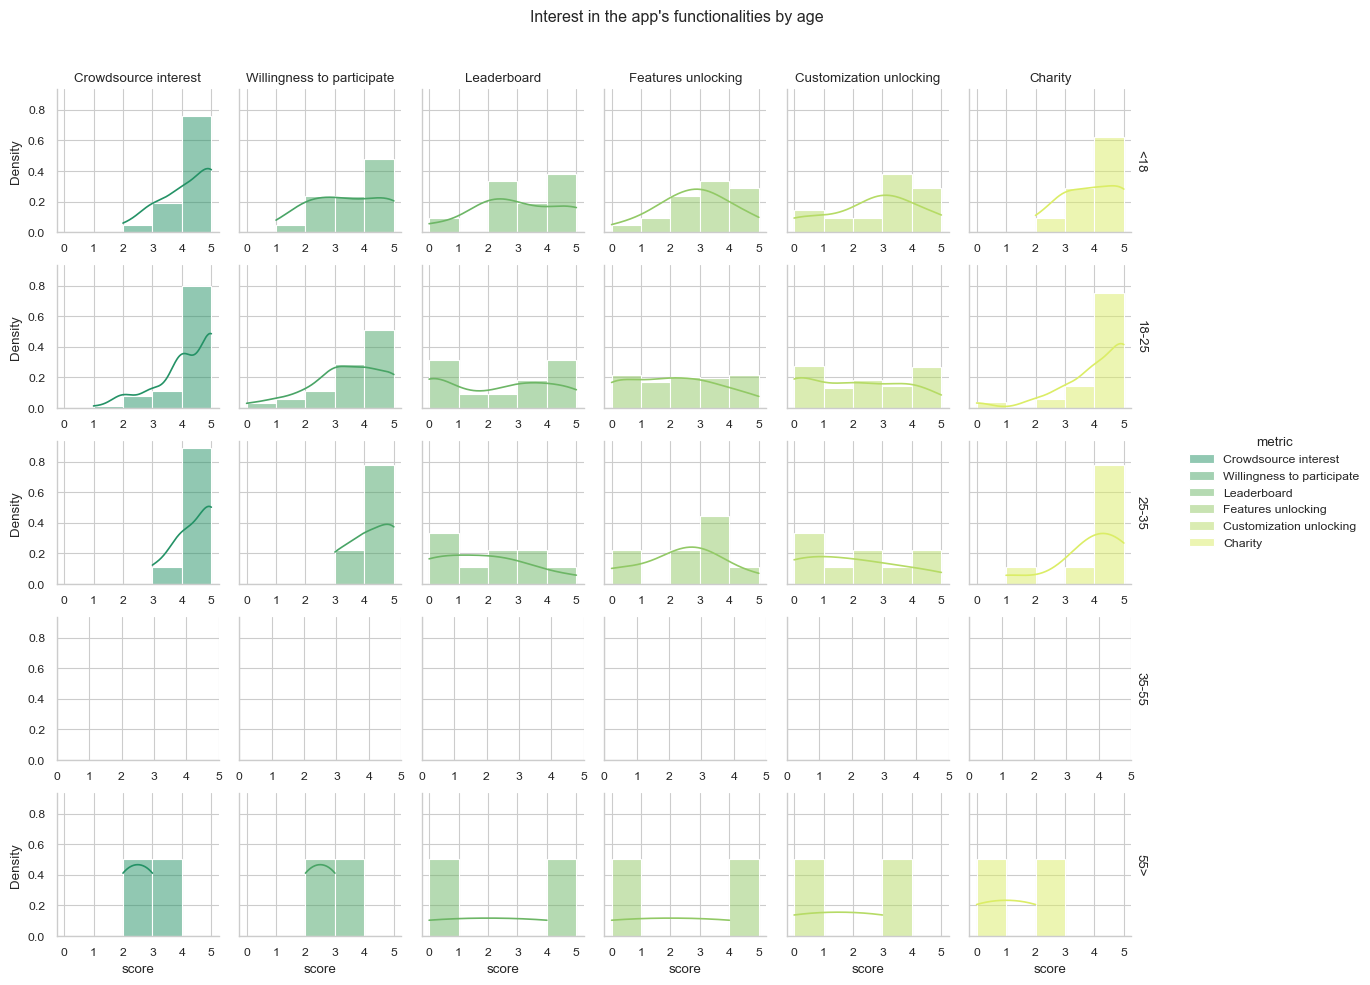

In [176]:

# define the list of metrics
metrics = ["interesse_crowdsource", "interesse_partecipazione", "interesse_classifica", "interesse_sblocco_feature", "interesse_sblocco_custom", "interesse_donazioni"]




human_readable_metrics = ["Crowdsource interest", "Willingness to participate", "Leaderboard", "Features unlocking", "Customization unlocking", "Charity"]

mapping = dict(zip(metrics, human_readable_metrics))

df = df.rename(columns=mapping)


# melt the DataFrame to tidy it up
tidy_df = df.melt(id_vars="eta", value_vars=human_readable_metrics, var_name="metric", value_name="score")

# create a FacetGrid to display the results
g = sns.FacetGrid(tidy_df, col="metric", row="eta", margin_titles=True, sharex=False, height=2, aspect=1.0, row_order=["<18", "18-25", "25-35", "35-55", "55>"],
                  dropna=True, col_order=human_readable_metrics, despine=True, hue="metric", palette="summer", hue_order=human_readable_metrics)

# set the title and the labels for each subplot

g.set_titles(col_template="{col_name}", row_template="{row_name}")


#set the xticks for each subplot
g.set(xticks=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0])

# plot the results using a histogram
g.map(sns.histplot, "score", bins=range(0, 6), alpha=0.5, stat="density", kde=True)

# add a legend to the plot
g.add_legend()

# display the plot

g.fig.suptitle("Interest in the app's functionalities by age")
g.fig.subplots_adjust(top=0.90)

plt.savefig("../report/img/analysis/interest_app_functionalities.svg", format="svg", bbox_inches = "tight")

Visto che sono il gruppo più significativo, concentriamoci su i giovani...

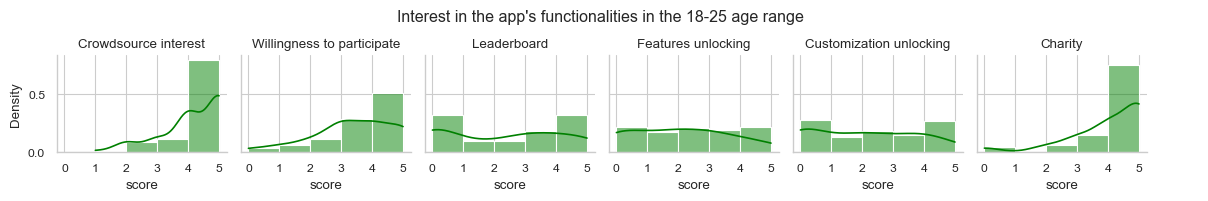

In [177]:
# plot the five metrics only for 18-25 years old users

# create a FacetGrid to display the results

g = sns.FacetGrid(tidy_df[tidy_df["eta"] == "18-25"], col="metric", margin_titles=True, sharex=False, height=2, aspect=1.0)

# set the title and the labels for each subplot

g.set_titles(col_template="{col_name}")

g.set_axis_labels("Score", "")

#set the xticks for each subplot

g.set(xticks=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0])

# plot the results using a histogram

g.map(sns.histplot, "score", bins=range(0, 6), alpha=0.5, stat="density", kde=True, color = "green")

# add a legend to the plot

g.add_legend()

# suptitle

g.fig.suptitle("Interest in the app's functionalities in the 18-25 age range")
g.fig.subplots_adjust(top=0.75)
plt.savefig("../report/img/analysis/interest_app_functionalities_18_25.svg", format="svg", bbox_inches = "tight")



Semplifichiamo e, per ogni metrica, mostriamo le preferenze delle varie età una accanto all altra

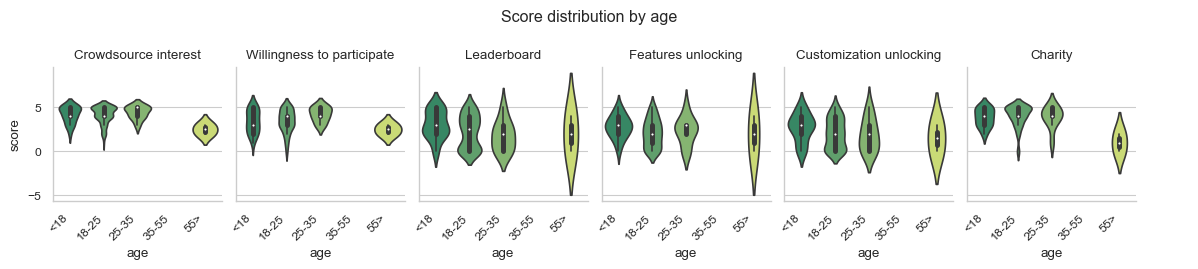

In [178]:
# show for each metric a boxplot with the distribution of the scores for each age group

# create a FacetGrid to display the results

tidy_df = tidy_df.rename(columns={"eta":"age"})

g = sns.FacetGrid(tidy_df, col="metric", margin_titles=True, sharex=False, height=2.5, aspect=0.8,
                  despine=True)

# set the title and the labels for each subplot

g.set_titles(col_template="{col_name}")

g.set_axis_labels("", "Score")

# plot the results using a violinplot
g.map(sns.violinplot, "age", "score", order=["<18", "18-25", "25-35", "35-55", "55>"], palette="summer")

# rotate the xticks
for ax in g.axes.flat:
    
        
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    

# display the plot
g.figure.subplots_adjust(top=0.75)
g.fig.suptitle("Score distribution by age")

g.add_legend()

# show

plt.savefig("../report/img/analysis/score_distribution_by_age.svg", format="svg", bbox_inches = "tight")


Semplifichiamo ulteriormente: ignoriamo i gruppi di età

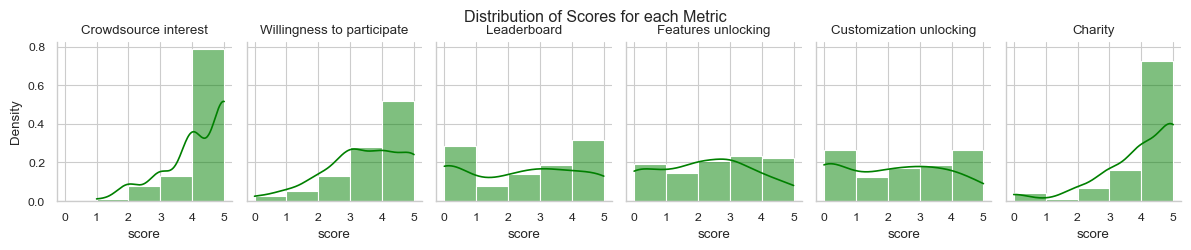

In [179]:
# create a FacetGrid to display the results
g = sns.FacetGrid(tidy_df, col="metric", margin_titles=True, sharex=False, height=2.5, aspect=0.8, despine=True)

# set the title and the labels for each subplot
g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "Density")

# plot the results using a histplot with kde
g.map(sns.histplot, "score", kde=True, bins=range(0, 6), stat="density", alpha=0.5, color="green")

# display the plot
g.fig.suptitle("Distribution of Scores for each Metric")
g.fig.subplots_adjust(top=0.85)

# set the xticks for each subplot

g.set(xticks=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0])

# show
plt.savefig("../report/img/analysis/distribution_of_scores_for_each_metric.svg", format="svg", bbox_inches = "tight")


In conclusione, diamo uno sguardo alle feature *approvate*, ovvero quelle che hanno ricevuto una 
maggioranza di voti $\geq 3$:

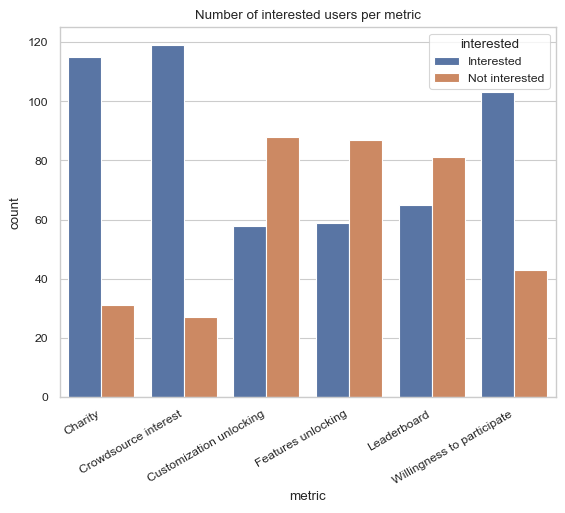

In [180]:
# For each metric, say if the majority of users are interested in it or not

tidy_df["interested"] = tidy_df["score"] >= 3

tidy_df["interested"] = tidy_df["interested"].replace({True: "Interested", False: "Not interested"})

# count the number of users for each metric and for each category

counts_df = tidy_df.groupby(["metric", "interested"]).size().reset_index(name="count")

# plot the results using a barplot

g = sns.barplot(x="metric", y="count", hue="interested", data=counts_df, hue_order=["Interested", "Not interested"])

plt.title("Number of interested users per metric")

g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.savefig("../report/img/analysis/interested_users_per_metric.svg", format="svg", bbox_inches = "tight")
